In [1]:
import os
import sys 
import yaml
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder

for i in search_subfolders(path_folder):
    sys.path.insert(0, i)

from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import seaborn as sbn
import numpy as np
import pandas as pd
from scipy import stats
import json
from class_load import LoadFiles
from factory_data import get_data, SQLDataSourceFactory
from factory_models import ModelContext, Modelos
from args_data_model import (
    ModelRNN,
    ModelBlockRNN,
    ModelExponentialSmoothing,
    ModelTCNModel,
    ModelFFT,
    ModelTransformerModel,
    ModelNBEATSModel,
    ModelDLinearModel,
    ModelNlinearModel,
    ModelTFTModel
)
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries
# from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.datasets import EnergyDataset,AirPassengersDataset
from darts.metrics import mape, r2_score

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
    FFT,
    ExponentialSmoothing,
    DLinearModel,
    NLinearModel
)
from factory_prepare_data import DataCleaner,MeanImputation,OutliersToIQRMean,DataModel

import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from DP_model import ModelHyperparameters, Modelos, Parameters_model
from darts.metrics import smape
import optuna
from optuna.integration import PyTorchLightningPruningCallback

attempted relative import with no known parent package


In [2]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [3]:
CONFIG_FILE = "/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/config/config.yaml"
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)
data = get_data(SQLDataSourceFactory(**parameters))

#Reempplazo de los tipo de datos por lo cuales 
#se va a cambiar el dataframe
new_types =[np.datetime64,int,int,'object',int,int]

#Estrategias para imputar los datos faltantes de NA 
strategy = {
    int:np.mean,
    float:np.mean,
    object:stats.mode
}

#metodo para transformar los tipo de datos
replace = {
    int:lambda x: int(float(x.replace(',',''))),
    float:lambda x: float(x.replace(',',''))
}

imputation = MeanImputation(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters
)

cleaner = DataCleaner(imputation)
data_for_process = cleaner.clean(data)


outliners = OutliersToIQRMean(
    **parameters
)
# outliners.clean(data_for_process.dataframe)
cleaner.strategy = outliners
filter_data = cleaner.clean(data_for_process.dataframe)

data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model

data_ready = cleaner.clean(filter_data)

data_,scalesr = data_ready
inverse_scale = scalesr.inverse_transform(data_)

In [4]:
model_name = 'NBeatsModel'
data = data_
split = 83

temp_df  = data.pd_dataframe().reset_index()

# Separacion de datos para entrenamiento
percent_split = int(temp_df.shape[0] * split/100)
split_value =temp_df.iloc[percent_split].values[0]
train, val = data.split_after(
    pd.Timestamp(split_value.strftime('%Y%m%d')))

# Cargar los parametros del modelo seleccionado
model_dict = Parameters_model[model_name]
model_used_parameters = model_dict().__dict__

In [5]:
callbacks=None
early_stopper = EarlyStopping("val_loss", min_delta=0.00001, patience=30, verbose=True)
if callbacks is None:
    callbacks = [early_stopper]
else:
    callbacks = [early_stopper] + callbacks

# detect if a GPU is available
if torch.cuda.is_available():
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        # "gpus": -1,
        # "auto_select_gpus": True,
        'enable_progress_bar':True,
        # "callbacks": callbacks,
    }
    num_workers = 4
else:
    pl_trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0

add_encoders={
'cyclic': {'past': ['month']},
'datetime_attribute': {'future': ['hour', 'dayofweek']},
'position': {'past': ['relative'], 'future': ['relative']}
}

In [6]:
if model_name != 'FFT':
    model_used_parameters['pl_trainer_kwargs']  = pl_trainer_kwargs
    # self.model_used_parameters['add_encoders'] = add_encoders

inst_model = Modelos[model_name]
model_prepare = inst_model(**model_used_parameters)

In [9]:
inst_model = Modelos[model_name]

In [11]:
inst_model.load_from_checkpoint(model_used_parameters['model_name'])

NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=4, optimizer_kwargs={'lr': 0.001}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

In [8]:
model_prepare.load_from_checkpoint()

darts.models.forecasting.nbeats.NBEATSModel

In [8]:
model_prepare = NBEATSModel(**model_used_parameters)

In [13]:
model_prepare

NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=4, optimizer_kwargs={'lr': 0.001}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True)

In [17]:
MAX_SAMPLES_PER_TS = 10
model_prepare.fit(
    series=train,
    val_series=val,
    # max_samples_per_ts=MAX_SAMPLES_PER_TS,
    # num_loader_workers=num_workers,
    verbose=True
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=4, optimizer_kwargs={'lr': 0.001}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

In [18]:
# temp_data = data.reset_index()

pred_series = model_prepare.historical_forecasts(
    data_,
    start= split_value,
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/67 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

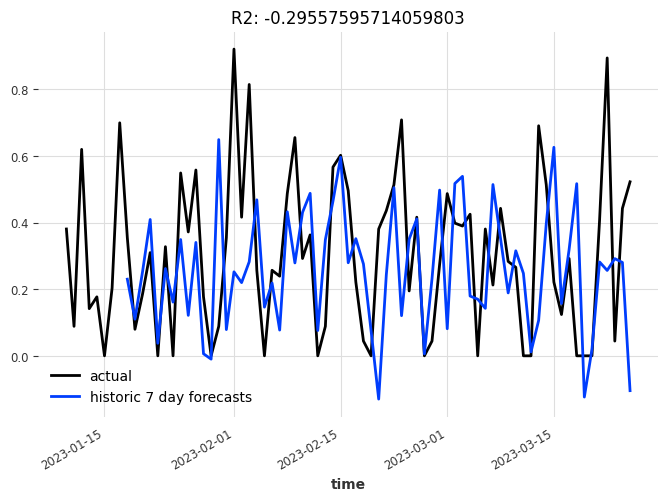

In [19]:
display_forecast(pred_series, data_, "7 day", start_date=split_value)

  0%|          | 0/126 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

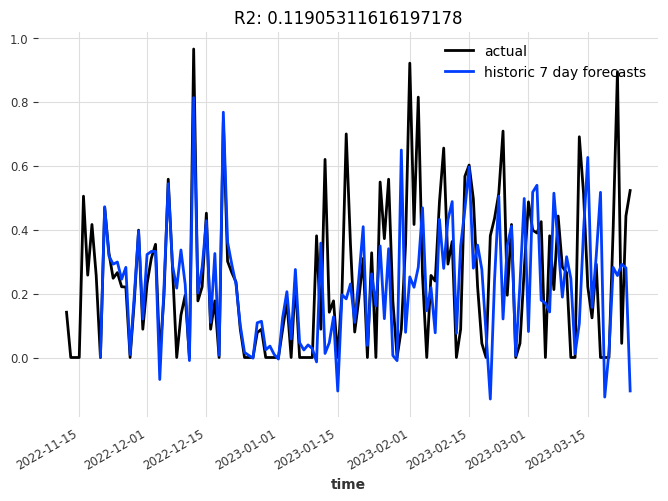

In [20]:
split_data ='20221111'

pred_series = model_prepare.historical_forecasts(
    data_,
    # series_transformed,
    start=pd.Timestamp(split_data),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))